## 0. Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf

from my_model import forward_prop, backward_prop, forward_prop_multi, backward_prop_multi
from opti_base import init_params, update_params_gd
from opti_mini import random_mini_batches
from opti_mome import init_mome, update_params_mome
from opti_RMSprop import init_rmsp, update_params_rmsp
from opti_adam import init_adam, update_params_adam

## 1. Dataset

In [2]:
f_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = f_mnist.load_data()

# images : 28*28 (0~255), labels : 1 (0~9)

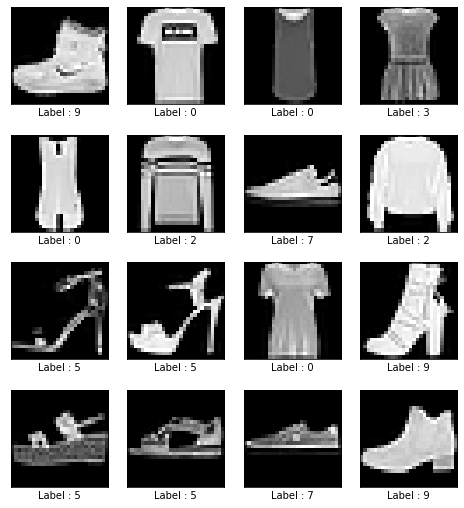

In [57]:
fig = plt.figure(figsize=(8,9))

for x in range(4):
    for y in range(4):
        ax = fig.add_subplot(4, 4, 4*y+x+1)
        plt.imshow(train_images[4*y+x], cmap = 'gray')
        plt.xlabel("Label : " + str(train_labels[4*y+x]))
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

In [4]:
print("Shape of train X :", train_images.shape)
print("Shape of train y :", train_labels.shape)
print("Shape of test X :", test_images.shape)
print("Shape of test y :", test_labels.shape)

Shape of train X : (60000, 28, 28)
Shape of train y : (60000,)
Shape of test X : (10000, 28, 28)
Shape of test y : (10000,)


In [5]:
# Flatten the training and test images
x_train_flatten = train_images.reshape(train_images.shape[0], -1).T
x_test_flatten = test_images.reshape(test_images.shape[0], -1).T

# Normalize image vectors
x_train = x_train_flatten/255.
x_test = x_test_flatten/255.

# Convert training and test labels to one hot matrices
enc = OneHotEncoder()
y1 = train_labels.reshape(-1,1)
enc.fit(y1)
y_train = enc.transform(y1).toarray()
y_train = y_train.T

y2 = test_labels.reshape(-1,1)
enc.fit(y2)
y_test = enc.transform(y2).toarray()
y_test = y_test.T

# Explore dataset 
print ("Shape of x train: " + str(x_train.shape))
print ("Shape of y train: " + str(y_train.shape))
print ("Shape of x test: " + str(x_test.shape))
print ("Shape of y test: " + str(y_test.shape))

Shape of x train: (784, 60000)
Shape of y train: (10, 60000)
Shape of x test: (784, 10000)
Shape of y test: (10, 10000)


## 2. Training

In [15]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10, print_cost = True):
    
    # 3-layer neural network
    
    L = len(layers_dims)            
    costs = []                      
    t = 0     # counter                  
    seed = 10                    
    m = X.shape[1]          
    
    # Initialize parameters
    parameters = init_params(layers_dims, Y.shape[0])

    # Initialize the optimizer
    if optimizer == "gd":
        pass   # no initialization required
    elif optimizer == "momentum":
        v = init_mome(parameters)
    elif optimizer == 'rmsprop':
        s = init_rmsp(parameters)
    elif optimizer == "adam":
        v, s = init_adam(parameters)
    
    for i in range(num_epochs):
        
        seed = seed + 1 # reshuffle differently the dataset after each epoch
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            # Forward prop
            a3, caches = forward_prop_multi(minibatch_X, parameters)
            logprobs = np.multiply(-np.log(a3),minibatch_Y)
            cost_total += np.sum(logprobs)

            # Backward prop
            grads = backward_prop_multi(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_params_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_params_mome(parameters, grads, v, beta, learning_rate)
            elif optimizer == 'rmsprop':
                parameters, s = update_params_rmsp(parameters, grads, s, beta, learning_rate, epsilon)
            elif optimizer == "adam":
                t = t + 1 # counter
                parameters, v, s = update_params_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        if print_cost and i % 1 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 1 == 0:
            costs.append(cost_avg)
                
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [27]:
def predict(X, y, parameters):

    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    a3, caches = forward_prop(X, parameters)
    
    p = a3.argmax(axis=0)  # prediction
    print(p, y)
    print("Accuracy: "  + str(np.mean((p == y))))
    
    return p, a3

- mini-batch Gradient descent

- **z1 = np.dot(W1, X) + b1**             
1024,784 * 784, 60000  
- **a1 = relu(z1)**                      
1024, 60000  
- **z2 = np.dot(W2, a1) + b2**            
784, 1024 * 1024, 60000  
- **a2 = relu(z2)**                       
784, 60000  
- **z3 = np.dot(W3, a2) + b3**            
10, 784 * 784, 60000  
- **a3 = softmax(z3)**                    
10 * 60000  

Cost after epoch 0: 2.302434
Cost after epoch 1: 2.302070
Cost after epoch 2: 2.301632
Cost after epoch 3: 2.301040
Cost after epoch 4: 2.300181
Cost after epoch 5: 2.298854
Cost after epoch 6: 2.296649
Cost after epoch 7: 2.292615
Cost after epoch 8: 2.284272
Cost after epoch 9: 2.263839


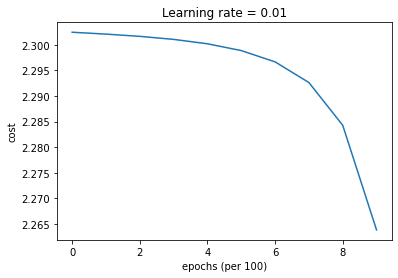

[9 4 1 ... 4 1 9] [9 2 1 ... 8 1 5]
Accuracy: 0.3741
Wall time: 35.1 s


In [34]:
%%time
layers_dims = [x_train.shape[0], 256, 64, 10]
parameters = model(x_train, y_train, layers_dims, optimizer = "gd", learning_rate = 0.01, mini_batch_size = 512)

predictions_gd, prob_gd = predict(x_test, test_labels, parameters)

- Momentum

Cost after epoch 0: 2.302457
Cost after epoch 1: 2.302104
Cost after epoch 2: 2.301685
Cost after epoch 3: 2.301129
Cost after epoch 4: 2.300335
Cost after epoch 5: 2.299133
Cost after epoch 6: 2.297191
Cost after epoch 7: 2.293772
Cost after epoch 8: 2.287095
Cost after epoch 9: 2.272065


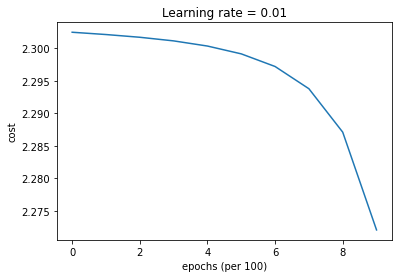

[9 4 1 ... 4 1 9] [9 2 1 ... 8 1 5]
Accuracy: 0.3943
Wall time: 36.7 s


In [39]:
%%time
layers_dims = [x_train.shape[0], 256, 64, 10]
parameters = model(x_train, y_train, layers_dims, optimizer = "momentum", learning_rate = 0.01, mini_batch_size = 512)

predictions_gd, prob_gd = predict(x_test, test_labels, parameters)

- RMSprop

In [41]:
%%time
layers_dims = [x_train.shape[0], 256, 64, 10]
parameters = model(x_train, y_train, layers_dims, beta = 0.999, optimizer = "rmsprop", mini_batch_size = 512)

# Predict
predictions_gd, prob_gd = predict(x_test, test_labels, parameters)

- ADAM

Cost after epoch 0: 1.151583
Cost after epoch 1: 0.602646
Cost after epoch 2: 0.513042
Cost after epoch 3: 0.466592
Cost after epoch 4: 0.434885
Cost after epoch 5: 0.415438
Cost after epoch 6: 0.397673
Cost after epoch 7: 0.387975
Cost after epoch 8: 0.371747
Cost after epoch 9: 0.362510


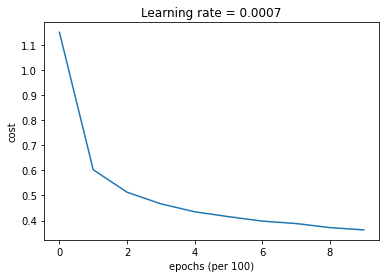

[9 2 1 ... 8 1 5] [9 2 1 ... 8 1 5]
Accuracy: 0.8525
Wall time: 47.5 s


In [42]:
%%time
layers_dims = [x_train.shape[0], 256, 64, 10]
parameters = model(x_train, y_train, layers_dims, optimizer = "adam", mini_batch_size = 512)

# Predict
predictions_gd, prob_gd = predict(x_test, test_labels, parameters)

### References
[1] Deep Learning Specialization on Coursera, https://www.coursera.org/specializations/deep-learning  
[2] Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).